In [1]:
import numpy as np
import os
from cv2 import cv2
import h5py
import matplotlib.pyplot as plt

In [2]:
def relu(a):
    z = np.zeros_like(a)
    return np.maximum(a, z)

def diff_relu(a):
    z = np.zeros_like(a)
    z[a > 0] = 1
    return z

def softmax(Z):
    Z = np.array(Z, dtype=np.float128)
    return np.exp(Z) / np.sum(np.exp(Z))

In [3]:
def check_point(model, ep, error):
    f = h5py.File('mlp_model_3_for_xray_ds_learned.hdf5', 'a')
    grp = f.create_group(f"epoch_{ep}")
    for i in range(len(model)):
        grp_l = grp.create_group(f"layer_{i}")
        dset = grp_l.create_dataset("weight", data=model[i][0])
        dset = grp_l.create_dataset("bias", data=model[i][1])
    dse = grp.create_dataset('error', data=error)
    f.close

In [30]:
def check_point_return(model, ep):
    f = h5py.File('mlp_model_for_xray_ds_learned.hdf5', 'r')
    epoch_grp = f[f"epoch_{ep}"]
    for i in range(len(model)):
        layer_grp = epoch_grp[f"layer_{i}"]
        model[i][0] = layer_grp['weight']
        model[i][1] = layer_grp['bias']
    error = epoch_grp['error']
    f.close
    return model, error

In [5]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    np.random.shuffle(data)
    return np.array(data)

In [6]:
train_data = get_training_data('/home/ilnar/Documents/Jupyter-notebooks/datasets/chest_xray/chest_xray/train')
test_data = get_training_data('/home/ilnar/Documents/Jupyter-notebooks/datasets/chest_xray/chest_xray/test')
val_data = get_training_data('/home/ilnar/Documents/Jupyter-notebooks/datasets/chest_xray/chest_xray/val')

OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/tmp/ipykernel_1987398/2387303108.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [7]:
X_train, y_train = train_data[:, 0], train_data[:, 1]
X_test, y_test = test_data[:, 0], test_data[:, 1]

In [8]:
for i in range(len(X_train)):
    X_train[i] = X_train[i].reshape(150*150,)
    
for i in range(len(X_test)):
    X_test[i] = X_test[i].reshape(150*150,)

In [9]:
X_train.shape

(5216,)

In [10]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [11]:
def layer(input_layer_count, output_layer_count):
    W = np.random.normal(0, 2/100, (output_layer_count, input_layer_count))
    b = np.ones((output_layer_count))
    print(W.shape)
    return [W, b]

In [12]:
def feed_forward(model, z):
    zs = [z]
    activations = []
    for i in range(len(model)):
        W, b = model[i]
        a = np.dot(W, zs[i]) + b
        z = relu(a)

        zs.append(z)
        activations.append(a)
    return activations, zs

def backpropagation(model, activations, zs, X_, grad_zlE, lr):
    for i in range(len(model) - 1, -1, -1):
        if i == 0:
            [W, b], a, z = model[i].copy(), activations[i], zs[i + 1]
            grad_aE = diff_relu(a) * grad_zlE
            grad_bE = grad_aE
            b = b - lr * grad_bE
            grad_w0E = grad_aE[np.newaxis].T * X_[np.newaxis]
            W = W - lr * grad_w0E
            model[i] = [W, b]
            break
        [W, b], a, z = model[i].copy(), activations[i], zs[i + 1]
        z_l_1 = zs[i]

        grad_aE = diff_relu(a) * grad_zlE

        grad_bE = grad_aE
        b = b - lr * grad_bE

        grad_wE = np.dot(grad_aE[np.newaxis].T, z_l_1[np.newaxis])
        
        W = W - lr * grad_wE

        grad_z_l_1E = np.dot(W.T, grad_aE)
        grad_zlE = grad_z_l_1E

        model[i] = [W, b]
    return model

def train(model, X_train, y_train, learning_rate=0.00001, epoch=1, record=False):
    step = 20
    lr = learning_rate
    E_xs = np.array([])
    try:
        for ep in range(epoch):
            print("epoch:", ep)
            index = 0
            E_xi = 0
            for l in range(len(X_train)):
                X_ = X_train[l]
                y_ = y_train[l]
                z = X_

                activations, zs = feed_forward(model, z)

                y = softmax(zs[-1])

                t = [1 if i == y_ else 0 for i in [0, 1]]
                E_xi = (- np.dot(t, np.log(y)))
                E_xs = np.append(E_xs, E_xi)

                #if y_ == 1:
                #    print(f"{index} iteration:", y_, ":", y)
                if index % step == 0:
                    print(f"{index} iteration: y = {y_}, predict {y}, loss: {E_xi}")
                    #print(f"{index} iteration: y={y_}, predict {y}, Max loss in ({index - step}, {index}): {E_xs[-step:].max()}")

                i = t.index(1)

                grad_yE = np.zeros_like(y)
                grad_yE[i] = -1 / y[i]

                grad_zlE = (y - t)

                model = backpropagation(model, activations, zs, X_, grad_zlE, lr)

                index += 1
                #if index == early_stop:
                #    return model, E_xs
            check_point(model, ep, E_xs)
    except KeyboardInterrupt:
        if record:
            check_point(model, f'eary_stopped', E_xs)
        print("Training is early stopped!")
        return model, E_xs
    return model, E_xs

In [14]:
model = [
    layer(img_size**2, 100),
    layer(100, 50),
    layer(50, 2)
]

(100, 22500)
(50, 100)
(2, 50)


In [25]:
model_1 = model.copy()

In [31]:
model_1, er = check_point_return(model_1, 'eary_stopped')

In [32]:
model_1, E_xs = train(model_1, X_train, y_train, learning_rate=0.0001, epoch=5)

epoch: 0
0 iteration: y = 0, predict [0.97260494 0.02739506], loss: 0.027777299514945973
20 iteration: y = 0, predict [0.78927956 0.21072044], loss: 0.2366347000403576
40 iteration: y = 1, predict [0.03094972 0.96905028], loss: 0.03143878333266517
60 iteration: y = 0, predict [0.99520509 0.00479491], loss: 0.004806440627444602
80 iteration: y = 0, predict [0.99165155 0.00834845], loss: 0.008383489977650814
100 iteration: y = 0, predict [0.97545238 0.02454762], loss: 0.024853938068210145
120 iteration: y = 0, predict [0.96972841 0.03027159], loss: 0.030739240933717348
140 iteration: y = 0, predict [0.57029901 0.42970099], loss: 0.5615944840510996
160 iteration: y = 0, predict [0.94356648 0.05643352], loss: 0.05808845568659124
180 iteration: y = 0, predict [0.69779084 0.30220916], loss: 0.35983587639091713
200 iteration: y = 1, predict [0.65675985 0.34324015], loss: 1.0693249226947485
220 iteration: y = 0, predict [0.96904362 0.03095638], loss: 0.031445656475335135
240 iteration: y = 0, 

2020 iteration: y = 0, predict [0.89509794 0.10490206], loss: 0.1108221389587132
2040 iteration: y = 0, predict [0.52631884 0.47368116], loss: 0.6418480895726177
2060 iteration: y = 0, predict [0.95094869 0.04905131], loss: 0.0502951721538602
2080 iteration: y = 0, predict [0.96008307 0.03991693], loss: 0.04073546807006066
2100 iteration: y = 0, predict [0.99623921 0.00376079], loss: 0.0037678816654201732
2120 iteration: y = 1, predict [0.51564369 0.48435631], loss: 0.7249344664487594
2140 iteration: y = 1, predict [0.13432502 0.86567498], loss: 0.1442457570856093
2160 iteration: y = 0, predict [0.96214397 0.03785603], loss: 0.038591187672443086
2180 iteration: y = 0, predict [0.99134274 0.00865726], loss: 0.008694954748045991
2200 iteration: y = 0, predict [0.97060949 0.02939051], loss: 0.02983106524774029
2220 iteration: y = 1, predict [0.07294174 0.92705826], loss: 0.07573887269130418
2240 iteration: y = 0, predict [0.92963543 0.07036457], loss: 0.07296277604873591
2260 iteration: y

4020 iteration: y = 0, predict [0.4557944 0.5442056], loss: 0.7857134501019909
4040 iteration: y = 0, predict [0.99087988 0.00912012], loss: 0.009161960732981356
4060 iteration: y = 0, predict [0.99613729 0.00386271], loss: 0.003870188511222291
4080 iteration: y = 0, predict [0.99681937 0.00318063], loss: 0.003185694750023738
4100 iteration: y = 0, predict [0.99583958 0.00416042], loss: 0.004169095791585784
4120 iteration: y = 0, predict [0.96700518 0.03299482], loss: 0.03355142993091328
4140 iteration: y = 0, predict [9.99200942e-01 7.99058316e-04], loss: 0.0007993777335611065
4160 iteration: y = 1, predict [0.77096584 0.22903416], loss: 1.4738841165566547
4180 iteration: y = 0, predict [0.34691058 0.65308942], loss: 1.0586882229652743
4200 iteration: y = 0, predict [0.98221768 0.01778232], loss: 0.017942323068651043
4220 iteration: y = 1, predict [0.14725418 0.85274582], loss: 0.15929375994575648
4240 iteration: y = 0, predict [0.99554649 0.00445351], loss: 0.0044634558068640156
4260

820 iteration: y = 0, predict [0.99164193 0.00835807], loss: 0.008393194738423551
840 iteration: y = 1, predict [0.00441583 0.99558417], loss: 0.004425607221036919
860 iteration: y = 0, predict [0.99639564 0.00360436], loss: 0.003610873810275487
880 iteration: y = 0, predict [0.97963992 0.02036008], loss: 0.020570203735849706
900 iteration: y = 0, predict [0.96617488 0.03382512], loss: 0.034410424716105024
920 iteration: y = 0, predict [0.99556311 0.00443689], loss: 0.004446757415193607
940 iteration: y = 0, predict [0.50115606 0.49884394], loss: 0.6908377243361649
960 iteration: y = 0, predict [0.99561851 0.00438149], loss: 0.004391114079643434
980 iteration: y = 1, predict [0.05647711 0.94352289], loss: 0.058134653797403145
1000 iteration: y = 0, predict [0.99670423 0.00329577], loss: 0.003301213149734862
1020 iteration: y = 0, predict [0.98147817 0.01852183], loss: 0.018695503255189382
1040 iteration: y = 0, predict [0.8866464 0.1133536], loss: 0.12030902834448946
1060 iteration: y 

2820 iteration: y = 1, predict [0.36831695 0.63168305], loss: 0.4593675160716172
2840 iteration: y = 0, predict [0.14211786 0.85788214], loss: 1.9510985427602625
2860 iteration: y = 0, predict [0.99729534 0.00270466], loss: 0.0027083218748593903
2880 iteration: y = 0, predict [0.98793955 0.01206045], loss: 0.012133768758281366
2900 iteration: y = 0, predict [0.99862241 0.00137759], loss: 0.0013785369781036435
2920 iteration: y = 0, predict [0.99248006 0.00751994], loss: 0.007548359303640926
2940 iteration: y = 0, predict [0.87090887 0.12909113], loss: 0.13821793957296793
2960 iteration: y = 0, predict [0.99835613 0.00164387], loss: 0.0016452240960042152
2980 iteration: y = 0, predict [0.94062367 0.05937633], loss: 0.06121214133690425
3000 iteration: y = 0, predict [0.99688194 0.00311806], loss: 0.003122926881679208
3020 iteration: y = 1, predict [0.01444311 0.98555689], loss: 0.014548425663805382
3040 iteration: y = 0, predict [0.99814353 0.00185647], loss: 0.0018581954371953732
3060 i

4820 iteration: y = 0, predict [0.84391047 0.15608953], loss: 0.16970886883777728
4840 iteration: y = 1, predict [0.42484963 0.57515037], loss: 0.5531237677023118
4860 iteration: y = 1, predict [0.08940892 0.91059108], loss: 0.09366135341047015
4880 iteration: y = 1, predict [0.14087793 0.85912207], loss: 0.15184425946070457
4900 iteration: y = 0, predict [0.98942916 0.01057084], loss: 0.010627107976186217
4920 iteration: y = 0, predict [0.9965996 0.0034004], loss: 0.0034061902994252245
4940 iteration: y = 0, predict [0.92049031 0.07950969], loss: 0.08284880702472437
4960 iteration: y = 0, predict [9.99356583e-01 6.43417319e-04], loss: 0.000643624401109682
4980 iteration: y = 0, predict [0.84605991 0.15394009], loss: 0.1671651105210601
5000 iteration: y = 0, predict [0.94353195 0.05646805], loss: 0.05812505353805612
5020 iteration: y = 0, predict [0.99746387 0.00253613], loss: 0.0025393470510960163
5040 iteration: y = 1, predict [0.15166269 0.84833731], loss: 0.1644769543708264
5060 it

1600 iteration: y = 1, predict [0.43104553 0.56895447], loss: 0.5639548685292936
1620 iteration: y = 0, predict [0.99779597 0.00220403], loss: 0.0022064580766978513
1640 iteration: y = 0, predict [0.99397117 0.00602883], loss: 0.006047076672901498
1660 iteration: y = 0, predict [0.97846286 0.02153714], loss: 0.02177244455162333
1680 iteration: y = 1, predict [0.05995127 0.94004873], loss: 0.06182356461567838
1700 iteration: y = 1, predict [0.05624558 0.94375442], loss: 0.0578892944497554
1720 iteration: y = 1, predict [0.00796001 0.99203999], loss: 0.007991857624073537
1740 iteration: y = 0, predict [0.74389902 0.25610098], loss: 0.29584997442073585
1760 iteration: y = 0, predict [0.97110953 0.02889047], loss: 0.029316010980447112
1780 iteration: y = 0, predict [0.99719246 0.00280754], loss: 0.0028114888717674247
1800 iteration: y = 0, predict [0.94445398 0.05554602], loss: 0.057148314825517355
1820 iteration: y = 0, predict [0.99821358 0.00178642], loss: 0.001788014312812933
1840 iter

3600 iteration: y = 0, predict [0.73192646 0.26807354], loss: 0.3120752383615586
3620 iteration: y = 0, predict [0.99897446 0.00102554], loss: 0.0010260691163657407
3640 iteration: y = 1, predict [0.00115946 0.99884054], loss: 0.001160133653380289
3660 iteration: y = 0, predict [0.99782741 0.00217259], loss: 0.002174953998020044
3680 iteration: y = 1, predict [0.02581254 0.97418746], loss: 0.026151532211373632
3700 iteration: y = 0, predict [0.99590106 0.00409894], loss: 0.00410736309961111
3720 iteration: y = 0, predict [0.94975021 0.05024979], loss: 0.051556268534013946
3740 iteration: y = 0, predict [0.9014447 0.0985553], loss: 0.1037565837481649
3760 iteration: y = 0, predict [0.99682782 0.00317218], loss: 0.0031772189095153214
3780 iteration: y = 0, predict [0.99740415 0.00259585], loss: 0.0025992256850154182
3800 iteration: y = 0, predict [0.81877489 0.18122511], loss: 0.19994609749582515
3820 iteration: y = 0, predict [9.99351525e-01 6.48475100e-04], loss: 0.000648685451384896
3

380 iteration: y = 1, predict [0.07837547 0.92162453], loss: 0.0816173737780705
400 iteration: y = 1, predict [0.09630657 0.90369343], loss: 0.10126509830274712
420 iteration: y = 1, predict [0.20214959 0.79785041], loss: 0.22583415495686446
440 iteration: y = 0, predict [0.7813548 0.2186452], loss: 0.24672594000351003
460 iteration: y = 0, predict [9.99542009e-01 4.57991290e-04], loss: 0.000458096200113075
Training is early stopped!


In [46]:
metrics(model_1, X_test, y_test)

Accuracy: 0.8028846153846154


In [33]:
E_xs.shape, type(E_xs)

((16126,), numpy.ndarray)

In [45]:
def np_max(l):
    max_idx = np.argmax(l)
    max_val = l[max_idx]
    return (max_idx, max_val)

def metrics(model, X_test, y_test):
    correct = 0
    total = len(y_test)
    for l in range(len(X_test)):
        X_ = X_test[l]
        y_ = y_test[l]
        t = [1 if i == y_ else 0 for i in [0, 1]]
        i = t.index(1)
        z = X_
        for layer in model:
            W, b = layer.copy()
            a = np.dot(W, z) + b
            z = relu(a)
        y = softmax(z)
        
        ind, val = np_max(y)
#         print(y_, ":", y[i], f"predict for {labels[ind]}:",  val)
        if ind == i:
            correct += 1
    print(f"Accuracy: {correct/total}")

161


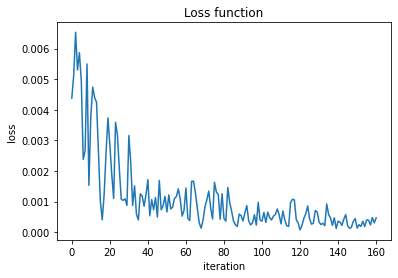

In [43]:
loss = np.array([])
step = 100
for i in range(step, len(E_xs), step):
    loss = np.append(loss, E_xs[i-step:i].min())
print(loss.size)
plt.plot(np.arange(len(loss)), loss)
plt.title("Loss function")
plt.ylabel("loss")
plt.xlabel("iteration")
plt.savefig("mlp_lear_loss")

In [209]:
check_point(model_1, 1, E_xs)

In [21]:
f = h5py.File('mlp_model_for_xray_ds_learned.hdf5', 'r')
def printname(name):
    print(name)

f.visit(printname)
f.close()

epoch_eary_stopped
epoch_eary_stopped/error
epoch_eary_stopped/layer_0
epoch_eary_stopped/layer_0/bias
epoch_eary_stopped/layer_0/weight
epoch_eary_stopped/layer_1
epoch_eary_stopped/layer_1/bias
epoch_eary_stopped/layer_1/weight
epoch_eary_stopped/layer_2
epoch_eary_stopped/layer_2/bias
epoch_eary_stopped/layer_2/weight


In [23]:
with h5py.File('mlp_model_for_xray_ds_learned.hdf5', 'r') as f:
    print(f.keys())
    epoch = f['epoch_eary_stopped']
    grp_l = epoch[f"layer_{0}"]
    print(list(epoch.keys()))
    test_weight = grp_l['weight']
    print(test_weight.shape)

<KeysViewHDF5 ['epoch_eary_stopped']>
['error', 'layer_0', 'layer_1', 'layer_2']
(100, 22500)


In [28]:
f.close()

In [29]:
if f: print("access")

In [213]:
np.array(model_1).shape

/tmp/ipykernel_3199146/1609336080.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(model_1).shape


(3, 2)

In [ ]:
model_2 = check_point_return(model_1, 1) # epoch or 'early_stopped'